In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import glob
import matplotlib.image as mpimg
from PIL import Image
import math
import os
import time

from utils import preprocess_data, next_batch, calculate_accuracy
IMG_SIZE = 32  # square image of size IMG_SIZE x IMG_SIZE
GRAYSCALE = True  # convert image to grayscale?
NUM_CHANNELS = 1 if GRAYSCALE else 3
NUM_CLASSES = 43

# Model parameters
LR = 1e-4  # learning rate
KEEP_PROB = 0.5  # dropout keep probability

NUM_EPOCH = 60
coef = 0.00005

1.15.5



In [2]:
training_file = "./train.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39209, 32, 32, 3)
y_train shape: (39209,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


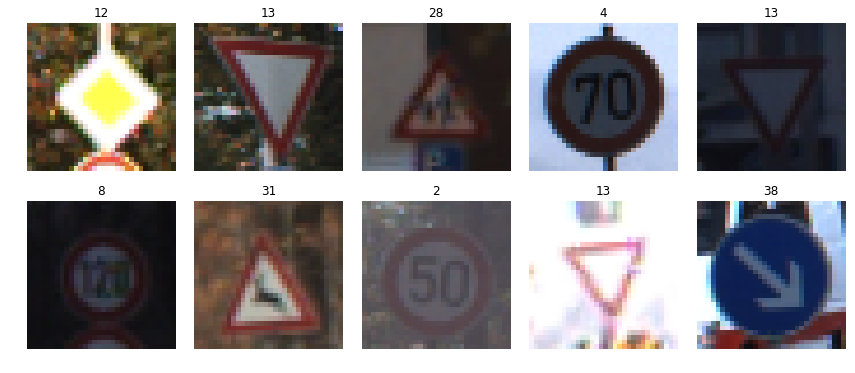

In [3]:
#Visualization the dataset
import matplotlib.pyplot as plt
import random
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

In [4]:
BATCH_SIZE = 100  # batch size for training (relatively small)
BATCH_SIZE_INF = 2048  # batch size for running inference, e.g. calculating accuracy
VALIDATION_SIZE = 0.2  # fraction of total training set to use as validation set

In [5]:
## Normalize the train and test datasets to (-1,1)
X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)
  


In [6]:
from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    #Activation.
    x = tf.nn.relu(x)
    
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    #Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    #Activation.
    x = tf.nn.relu(x)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    #Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    #Activation.
    x = tf.nn.relu(x)
    layer3 = x

    #Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    #Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    

    
    return logits

print('done')

done


In [7]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, IMG_SIZE, IMG_SIZE, 3))
y = tf.placeholder(tf.float32, (None, NUM_CLASSES))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
print('done')

done


In [8]:
logits = LeNet2(x)
rate = 0.0009

correct_logit = tf.reduce_sum(y * logits, axis=1)
wrong_logit = tf.reduce_max((1-y) * logits, axis=1)
reg_loss =  correct_logit - wrong_logit
cw_grad = tf.gradients(reg_loss,x)[0]
vis = tf.gradients(correct_logit,x)[0]

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss_operation = tf.reduce_mean(cross_entropy)

grad = tf.gradients(loss_operation,x)[0]
grad_loss = tf.nn.l2_loss(grad)
predictions = tf.argmax(logits, 1)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation+50*grad_loss)

predictions = tf.argmax(logits, 1)
correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("done")

layer 1 shape: (?, 28, 28, 6)
layer2flat shape: (?, 400)
xflat shape: (?, 400)
x shape: (?, 800)
done


In [9]:
global_step = tf.train.get_or_create_global_step()

grad_loss = coef * tf.reduce_sum(tf.nn.l2_loss(cw_grad))

total_loss = loss_operation + grad_loss

training_operation = optimizer.minimize(total_loss, global_step=global_step)

print("done")

done


In [10]:
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [11]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Let's start the training...")
    print()
    for i in range(NUM_EPOCH):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'rein_model')
    print("Model saved")

Let's start the training...

EPOCH 1 ...
Validation Accuracy = 0.878

EPOCH 2 ...
Validation Accuracy = 0.940

EPOCH 3 ...
Validation Accuracy = 0.961

EPOCH 4 ...
Validation Accuracy = 0.963

EPOCH 5 ...
Validation Accuracy = 0.971

EPOCH 6 ...
Validation Accuracy = 0.974

EPOCH 7 ...
Validation Accuracy = 0.979

EPOCH 8 ...
Validation Accuracy = 0.976

EPOCH 9 ...
Validation Accuracy = 0.981

EPOCH 10 ...
Validation Accuracy = 0.980

EPOCH 11 ...
Validation Accuracy = 0.982

EPOCH 12 ...
Validation Accuracy = 0.984

EPOCH 13 ...
Validation Accuracy = 0.985

EPOCH 14 ...
Validation Accuracy = 0.985

EPOCH 15 ...
Validation Accuracy = 0.984

EPOCH 16 ...
Validation Accuracy = 0.985

EPOCH 17 ...
Validation Accuracy = 0.987

EPOCH 18 ...
Validation Accuracy = 0.984

EPOCH 19 ...
Validation Accuracy = 0.985

EPOCH 20 ...
Validation Accuracy = 0.986

EPOCH 21 ...
Validation Accuracy = 0.986

EPOCH 22 ...
Validation Accuracy = 0.987

EPOCH 23 ...
Validation Accuracy = 0.989

EPOCH 24 ...
V

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./rein_model.meta')
    saver2.restore(sess, "./rein_model")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./rein_model
Test Set Accuracy = 0.939


Rain 


$$
X_{rain} = Mp * X_{org} + \alpha 1 - Mp * Rain, 
$$
$X_{org}$ = original, 
$X_{rain}$ = observed image,

In [12]:
import copy
def rain(images, eps):
    x = copy.copy(images)
    batch_size = images.shape[0]
    for i in range(batch_size):
       # if np.mean(x[i]) > 100 and i < 1:
        #    x[i] = x[i] / (1+eps*0.15)
        for j in range(eps*40):
            np.random.seed(j)
            x_idx = np.random.randint(0, 32)
            y_idx = np.random.randint(0, 32)
            x[i, x_idx:x_idx+2, y_idx, :] = 0.8*x[i, x_idx:x_idx+2, y_idx, :] + 0.2*255
    x = np.clip(x, 0., 255.)
    return x
    

In [13]:
def fog(images, eps):
    x = copy.copy(images)
    batch_size = images.shape[0]
#     x = x / (eps*0.3+1) + eps * 10
    x = x *(1-eps*0.04) + eps * 7
#     for i in range(batch_size):
#         image = x[i].reshape(32, 32, 3)
#         temp = gaussian_filter(image, sigma=0.7)
#         x[i] = temp
    x = np.clip(x, 0., 255.)
    return x

In [14]:
import copy
def dark(images, eps):
    x = copy.copy(images)
    x = x - eps*10.
    x = np.clip(x, 0., 255.)
    return x

def light(images, eps):
    x = copy.copy(images)
    x = x + eps*10.
    x = np.clip(x, 0., 255.)
    return x

In [15]:
from scipy.ndimage.filters import gaussian_filter

def blur(images, eps):
    batch_size = images.shape[0]
    x = np.zeros(images.shape)
    for i in range(batch_size):
        image = images[i].reshape(32, 32, 1)
        temp = gaussian_filter(image, sigma=0.5+eps*0.1)
        x[i] = temp
    return x

In [16]:
def ocul(images, eps):
    batch_size = images.shape[0]
    x = copy.copy(images)
    for i in range(batch_size):
        image = images[i].reshape(32, 32, 3)
        idx = np.random.randint(0, 32-eps)
        x[i, idx:idx+eps, idx:idx+eps, :] = 0.
#         x[i] = image
    return x

In [17]:
testing_file = "./test_aug.p"

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (13630, 32, 32, 3)
y_test shape: (13630,)


In [18]:
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)


X_test= (X_test - 128)/128

In [19]:
rain_images = rain(X_test, 1)

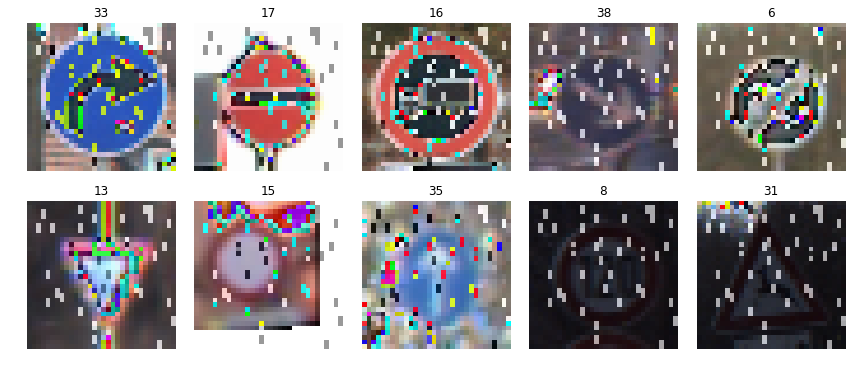

In [21]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(rain_images))
    image = rain_images[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_test[index])
    

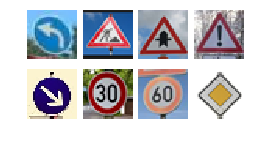

In [22]:
#reading in an image
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(2,4, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./traffic-signs-test/*x.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image = np.reshape(image, (32, 32, 3))
    my_images.append(image)

my_images = np.asarray(my_images,dtype='uint8')
copy_images = my_images



In [23]:
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string

In [24]:
print(label_map)

{0: 'Speed limit (20km/h)\n', 1: 'Speed limit (30km/h)\n', 2: 'Speed limit (50km/h)\n', 3: 'Speed limit (60km/h)\n', 4: 'Speed limit (70km/h)\n', 5: 'Speed limit (80km/h)\n', 6: 'End of speed limit (80km/h)\n', 7: 'Speed limit (100km/h)\n', 8: 'Speed limit (120km/h)\n', 9: 'No passing\n', 10: 'No passing for vechiles over 3.5 metric tons\n', 11: 'Right-of-way at the next intersection\n', 12: 'Priority road\n', 13: 'Yield\n', 14: 'Stop\n', 15: 'No vechiles\n', 16: 'Vechiles over 3.5 metric tons prohibited\n', 17: 'No entry\n', 18: 'General caution\n', 19: 'Dangerous curve to the left\n', 20: 'Dangerous curve to the right\n', 21: 'Double curve\n', 22: 'Bumpy road\n', 23: 'Slippery road\n', 24: 'Road narrows on the right\n', 25: 'Road work\n', 26: 'Traffic signals\n', 27: 'Pedestrians\n', 28: 'Children crossing\n', 29: 'Bicycles crossing\n', 30: 'Beware of ice/snow\n', 31: 'Wild animals crossing\n', 32: 'End of all speed and passing limits\n', 33: 'Turn right ahead\n', 34: 'Turn left ahea

In [25]:


my_images, _ = preprocess_data(my_images, np.array([0 for _ in range(my_images.shape[0])]))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./rein_model.meta')
    saver3.restore(sess, "./rein_model")
    lgts, preds = sess.run([logits, predictions], feed_dict={x: my_images, keep_prob: 1.})
    final_preds = [label_map[pred] for pred in preds]



INFO:tensorflow:Restoring parameters from ./rein_model


In [26]:
# Print predictions on my sample images
print('Predictions on sample images\n')
for i in range(my_images.shape[0]):
    print('%s' % (final_preds[i]))

Predictions on sample images

Turn left ahead

Turn right ahead

Right-of-way at the next intersection

General caution

Keep right

Speed limit (30km/h)

Speed limit (60km/h)

Roundabout mandatory



In [27]:
with tf.Graph().as_default(), tf.Session() as sess:
    logits = tf.placeholder('float', [None, NUM_CLASSES])
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={logits: lgts})

In [34]:
def display_pred_certainty(copy_image, image, top_k_val, top_k_idx):
    print('Top 5 predictions for the following image (prediction: probability)')
    # Convert top k indices into strings
    top_k_pred = [label_map[idx] for idx in top_k_idx]
    
    # Show the image for reference
    fig, axs = plt.subplots(1,2, figsize=(10, 3))
    axs = axs.ravel();
    axs[0].axis('off')
    axs[0].imshow(copy_image)
    
    for i in range(5):
        print('%s: %.2f%%' % (top_k_pred[i].replace('\n', ''), top_k_val[i] * 100))

Top 5 predictions for the following image (prediction: probability)
Turn left ahead: 44.49%
No passing: 18.63%
Speed limit (20km/h): 18.42%
Stop: 11.35%
Children crossing: 1.66%


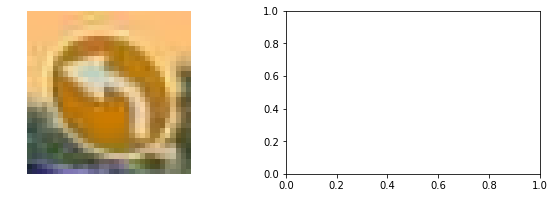

In [35]:
i = 0
display_pred_certainty(copy_images[i],my_images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)
Turn right ahead: 49.88%
Road work: 16.52%
Speed limit (30km/h): 15.05%
Keep left: 8.94%
Ahead only: 7.50%


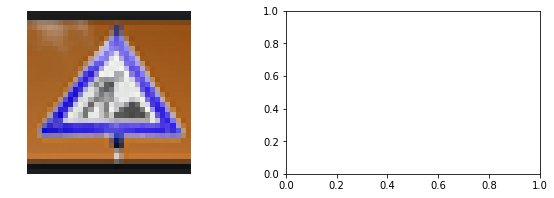

In [38]:
i = 1
display_pred_certainty(copy_images[i],my_images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)
Right-of-way at the next intersection: 100.00%
Beware of ice/snow: 0.00%
Turn left ahead: 0.00%
Slippery road: 0.00%
Double curve: 0.00%


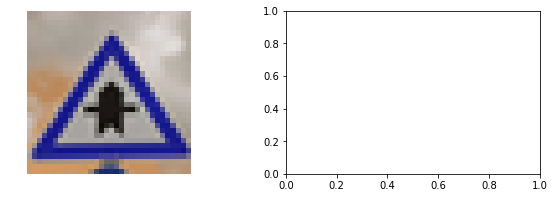

In [39]:
i = 2
display_pred_certainty(copy_images[i],my_images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)
General caution: 100.00%
Right-of-way at the next intersection: 0.00%
Traffic signals: 0.00%
Pedestrians: 0.00%
Road work: 0.00%


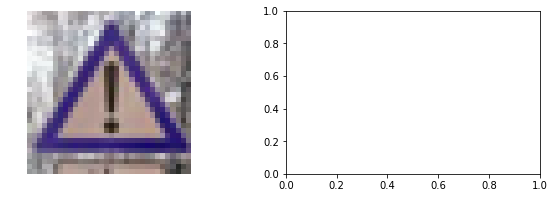

In [40]:
i = 3
display_pred_certainty(copy_images[i],my_images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)
Keep right: 100.00%
Speed limit (50km/h): 0.00%
Slippery road: 0.00%
Speed limit (30km/h): 0.00%
Speed limit (20km/h): 0.00%


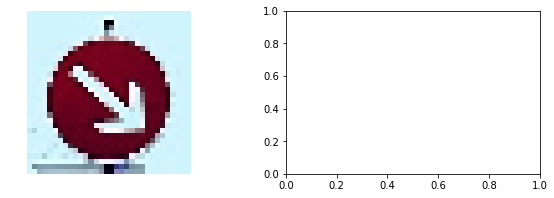

In [42]:
i = 4
display_pred_certainty(copy_images[i],my_images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)
Speed limit (30km/h): 96.35%
Speed limit (80km/h): 2.01%
Speed limit (50km/h): 1.61%
No passing for vechiles over 3.5 metric tons: 0.01%
Speed limit (70km/h): 0.00%


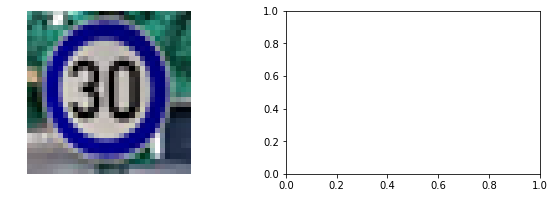

In [43]:
i = 5
display_pred_certainty(copy_images[i],my_images[i], top_k_vals[i], top_k_idxs[i])